# DTSC 2302 Final Project (Regression Model)


### Importing and Setting Up the Notebook


In [1]:
import pandas as pd  # noqa: F401
from pandas import DataFrame, Series  # noqa: F401
import numpy as np  # noqa: F401
from numpy import ndarray  # noqa: F401
import sklearn.model_selection as model_sel  # noqa: F401
import sklearn.linear_model as lin_model  # noqa: F401
import sklearn.metrics as mets
import statsmodels.api as sm  # noqa: F401
import matplotlib.pyplot as plt
import seaborn as sns  # noqa: F401

from project_helper import (
    get_npa_records,
    trn_vld_tst_split,
    standardize_df,
    top_k_feats,
    get_recent_cols,  # noqa: F401
    get_2023_cols,
)

from typing import Generator, List, Sequence, Tuple  # noqa: F401
from warnings import simplefilter
import math
import itertools  # noqa: F401

In [2]:
simplefilter(action="ignore", category=RuntimeWarning)  # Hides warnings

np.random.seed(4)  # Setting random seed

## Data Import


In [23]:
df = pd.read_csv("data/cleaned_data.csv", index_col="NPA")
df_2023_cols = pd.read_csv("data/cleaned_data_2023_only.csv", index_col="NPA")
df_recent_cols = pd.read_csv("data/cleaned_data_recent_only.csv", index_col="NPA")

In [24]:
df_2023_cols.drop(columns=["Public_Nutrition_Assistance-2023"], inplace=True)
df_2023_cols.dropna(inplace=True)
df_2023_cols

,Impervious_Surface-2023,Housing_Density-2023,Housing_Size-2023,Housing_Age-2023,New_Residential-2023,Residential_Renovation-2023,Vacant_Land-2023,Commercial_Construction-2023,Early_Care_Proximity-2023,School_Age_Proximity-2023,...,Neighborhood_School_Attendance-2023,Housing_Violations-2023,Foreclosures-2023,Adopt_a_Street-2023,Board_Committee_Participation-2023,Park_Proximity-2023,Home_Sale_Price-2023,Fincancial_Services_Proximity-2023,Subsidized_Housing-2023,Residential_Demolitions-2023
NPA,,,,,,,,,,,,,,,,,,,,,
2,23.433162,2.8,1720.0,70.0,1.2,4.1,5.143479,1.7,37.764085,79.401408,...,0.429043,0.616197,0.0,39.164367,0.000000,59.066901,488364.0,24.471831,4.428698,2.6
3,38.166350,8.4,2807.0,73.0,17.6,7.1,2.133670,10.6,89.437345,79.657873,...,0.684129,0.061830,0.0,57.190015,0.990017,91.477741,667092.0,100.000000,3.889542,0.6
5,21.546276,2.1,1195.0,61.0,31.1,0.6,21.346496,1.2,99.425287,99.425287,...,0.567376,3.448276,0.0,25.123656,0.000000,100.000000,255031.0,18.965517,0.000000,2.9
8,16.367318,2.0,2081.0,55.0,0.0,3.0,2.031648,3.0,15.068493,12.756849,...,0.540541,0.171233,0.0,45.980232,1.078749,100.000000,529911.0,45.719178,14.075993,1.7
11,29.617793,2.5,2934.0,54.0,3.5,8.3,2.668863,1.4,82.507987,83.067093,...,0.595238,0.000000,0.0,51.695848,2.133713,100.000000,1024397.0,49.361022,0.000000,9.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,21.648203,3.0,1479.0,57.0,0.3,3.7,1.120250,0.2,90.411373,78.402904,...,0.566923,0.574713,0.0,37.311932,0.618965,91.016334,377636.0,29.189353,10.330203,0.0
392,29.178050,2.7,3782.0,66.0,1.4,10.8,0.847860,3.3,61.414297,60.158852,...,0.714876,0.076864,0.0,37.830188,0.512768,88.624135,1269903.0,48.219318,0.000000,4.4
393,29.683866,4.2,1651.0,65.0,0.4,7.9,0.626032,3.5,49.510623,45.882072,...,0.597190,0.167104,0.0,45.269544,1.829370,93.554548,482354.0,77.894486,1.186153,0.7


## Data Exploration


IndexError: index 32 is out of bounds for axis 0 with size 32

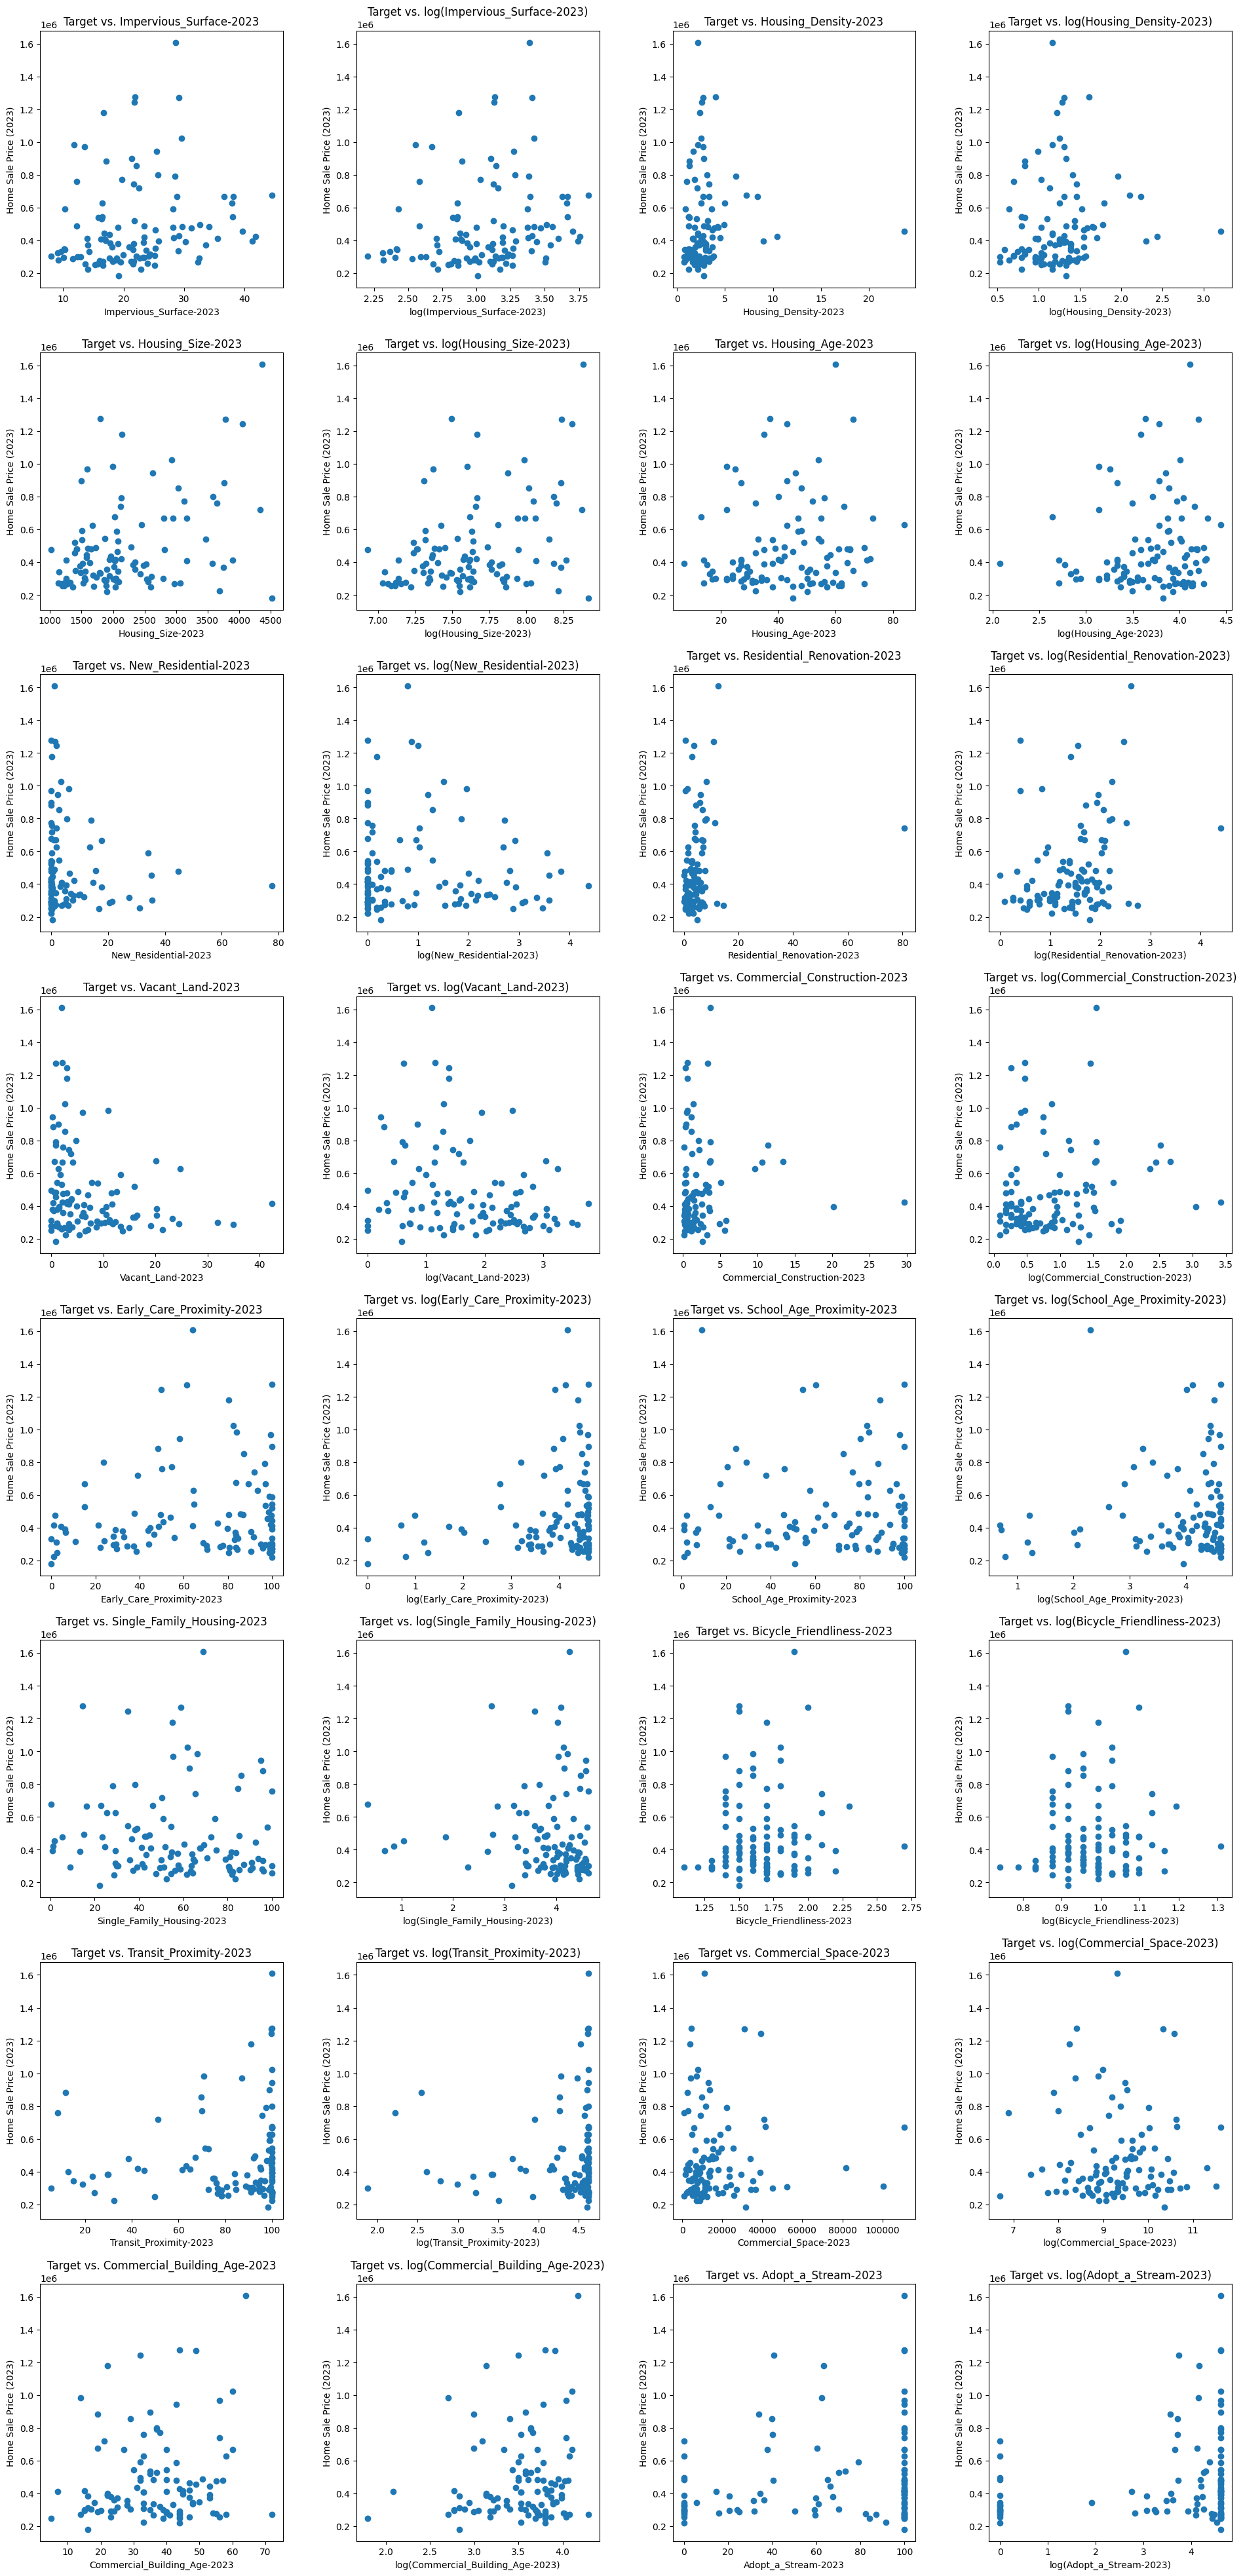

In [25]:
features = df_2023_cols.drop(columns="Home_Sale_Price-2023").columns

y = df_2023_cols["Home_Sale_Price-2023"]

num_features = len(features)
rows = math.ceil(num_features / 4)

fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
fig.tight_layout(pad=5)

axes = axes.ravel()

for i, feature in enumerate(features):
    axes[2 * i].scatter(df_2023_cols[feature], y)
    axes[2 * i].set_title(f"Target vs. {feature}")
    axes[2 * i].set_xlabel(feature)
    axes[2 * i].set_ylabel("Home Sale Price (2023)")

    log_feature = f"log({feature})"
    log_values = np.log1p(df_2023_cols[feature])
    axes[2 * i + 1].scatter(log_values, y)
    axes[2 * i + 1].set_title(f"Target vs. log({feature})")
    axes[2 * i + 1].set_xlabel(log_feature)
    axes[2 * i + 1].set_ylabel("Home Sale Price (2023)")


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


In [33]:
X = df_2023_cols.copy()
X["Log-Single_Family_Housing-2023"] = np.log1p(X["Single_Family_Housing-2023"])
X = X[["Log-Single_Family_Housing-2023"]]

y = df_2023_cols[["Home_Sale_Price-2023"]]

model = lin_model.LinearRegression(fit_intercept=True)
y_hat = model.fit(X, y).predict(X)

print(mets.r2_score(y, y_hat))

0.0031496306876320768


### Helper Functions

Functions to help with data cleaning and preprocessing.

Functions:

- `trn_vld_tst_split`:
  - Accepts a dataframe or ndarray of features, a series or ndarray of targets, and a training size (80% by default)
  - Returns splits of data


In [16]:
X = dropped_df.drop(columns="Home_Sale_Price-2023")
# X = sm.add_constant(X)
y = dropped_df["Home_Sale_Price-2023"]

X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = trn_vld_tst_split(X, y, 0.6)

print([split.shape for split in [X_trn, y_trn, X_vld, y_vld, X_tst, y_tst]])

[(64, 33), (64,), (21, 33), (21,), (23, 33), (23,)]


### <span style="color:red; font-weight:bold">Warning!</span>

<span style="color:red; font-weight:bold">Be cautious of the number of jobs running! If you are unsure how many cores your device has, set `n_jobs` to 1 or delete the argument from your method call.</span>


In [17]:
result = top_k_feats(
    7, X_trn, y_trn, X_vld=X_vld, y_vld=y_vld, use_metric="r2", n_jobs=-1, candidates=3
)
print(result)

Total possible combinations: 4272048


KeyboardInterrupt: 

In [20]:
test_df = dropped_df[get_2023_cols(dropped_df)]

In [21]:
test_df = test_df[
    [
        "Housing_Size-2023",
        "Early_Care_Proximity-2023",
        "School_Age_Proximity-2023",
        "Commercial_Building_Age-2023",
        "Log-Park_Proximity-2023",
        "Home_Sale_Price-2023",
    ]
]
test_df

Var_Name_Year,Housing_Size-2023,Early_Care_Proximity-2023,School_Age_Proximity-2023,Commercial_Building_Age-2023,Log-Park_Proximity-2023,Home_Sale_Price-2023
NPA,,,,,,
2,1720.0,37.764085,79.401408,51.0,4.095459,488364.0
3,2807.0,89.437345,79.657873,60.0,4.526968,667092.0
5,1195.0,99.425287,99.425287,56.0,4.615121,255031.0
8,2081.0,15.068493,12.756849,37.0,4.615121,529911.0
11,2934.0,82.507987,83.067093,60.0,4.615121,1024397.0
...,...,...,...,...,...,...
389,1479.0,90.411373,78.402904,47.0,4.521966,377636.0
392,3782.0,61.414297,60.158852,49.0,4.495625,1269903.0
393,1651.0,49.510623,45.882072,40.0,4.549177,482354.0


In [22]:
plot_rows = len(test_df.columns) // 5 + 1
plot_cols = 5

plt.figure(figsize=(20, 20))

y = test_df["Home_Sale_Price-2023"]

for i, col in enumerate(
    test_df.columns[20:40],
    1,
):
    x = test_df[col]
    plt.subplot(plot_rows, plot_cols, i)
    plt.scatter(x, y)
    plt.xlabel(col)
    plt.ylabel("Sale Price")

<Figure size 2000x2000 with 0 Axes>

In [ ]:
# plt.figure(figsize=(50, 50))
# sns.heatmap(corr_mat, annot=True, cmap="coolwarm")

In [28]:
test_df.dropna(inplace=True)

X = test_df[
    [
        "Log-Park_Proximity-2023",
    ]
]
# X = sm.add_constant(X)
y = test_df["Home_Sale_Price-2023"]

X_trn, X_tst, y_trn, y_tst = model_sel.train_test_split(X, y, test_size=0.25)

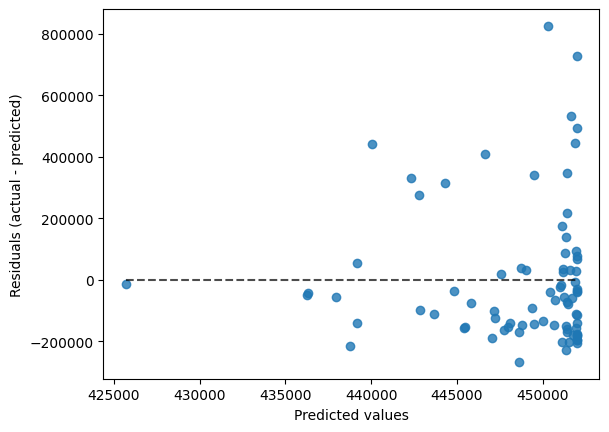

0.00048237522237859487


In [31]:
lin_reg = lin_model.LinearRegression(fit_intercept=True).fit(X_trn, y_trn)
y_hat = lin_reg.predict(X_trn)

mets.PredictionErrorDisplay.from_predictions(y_trn, y_hat)
plt.show()

print(mets.r2_score(y_trn, y_hat))

In [ ]:
X_trn = sm.add_constant(X_trn)

lin_reg = sm.OLS(y_trn, X_trn).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Home_Sale_Price-2023   R-squared:                       0.235
Model:                              OLS   Adj. R-squared:                  0.220
Method:                   Least Squares   F-statistic:                     16.09
Date:                  Wed, 30 Apr 2025   Prob (F-statistic):           7.88e-14
Time:                          09:48:14   Log-Likelihood:                -3711.8
No. Observations:                   268   AIC:                             7436.
Df Residuals:                       262   BIC:                             7457.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -3.182e+06   4.59e+05     -6.928      0.000   -4.09e+06   -2.28e+06
Housing_Size-2023             4.579e+05   5.59e+04      8.194      0.000    3.48e+05    5.68e+05
Early_Care_Proximity-2023     1325.6920    861.795      1.538      0.125    -371.233    3022.617
School_Age_Proximity-2023    -1220.9900    897.319     -1.361      0.175   -2987.865     545.885
Commercial_Building_Age-2023  4790.8427   1250.057      3.832      0.000    2329.405    7252.280
Park_Proximity-2023            112.9747    540.661      0.209      0.835    -951.618    1177.568
==============================================================================
Omnibus:                      179.521   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1963.730
Skew:                           2.571   Prob(JB):                         0.00
Kurtosis:                      15.224   Cond. No.                     3.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""